In [1]:
from post_processing import Analysis
import h5py
import numpy as np
import util

In [2]:
analysis = Analysis("diags202403070123")

In [11]:
file[f"data/{analysis.steps[frame]}"].keys()

<KeysViewHDF5 ['fields']>

In [5]:
frame = 50
species = "ions"
file = h5py.File(f"{analysis.dirname}/diag/{analysis.files[frame]}", "r")
val = np.array(file[f"data/{analysis.steps[frame]}/particles/{species}/position/x"])
val
# x = np.array(file[f"data/{analysis.steps[frame]}/particles/{species}/position/x"])
# y = np.array(file[f"data/{analysis.steps[frame]}/particles/{species}/position/y"])
# z = np.array(file[f"data/{analysis.steps[frame]}/particles/{species}/position/z"])
# r = np.sqrt(x**2 + y**2)
# mx = np.array(file[f"data/{analysis.steps[frame]}/particles/{species}/momentum/x"])
# mx
# my = np.array(file[f"data/{analysis.steps[frame]}/particles/{species}/momentum/y"])
# mz = np.array(file[f"data/{analysis.steps[frame]}/particles/{species}/momentum/z"])
# mr = np.sqrt(mx**2 + my**2)
# w = np.array(file[f"data/{analysis.steps[frame]}/particles/{species}/weighting"])

KeyError: 'Unable to open object (component not found)'

In [20]:
file[f"data/{analysis.st1eps[frame]}/particle"].keys()

AttributeError: 'Analysis' object has no attribute 'st1eps'

In [7]:
# logical coordinates and scatter ratios
# j=int(r/dr), j_frac=(r-rj)/dr where rj=dr*j
j_frac, j = np.modf(r / analysis.params.dr)
# need to shift the z to positive since k (an index) is positive
k_frac, k = np.modf((z + analysis.params.Lz / 2) / analysis.params.dz)
j = j.astype(int)
k = k.astype(int)
ratio1 = (1 - j_frac) * (1 - k_frac)
ratio2 = (j_frac) * (1 - k_frac)
ratio3 = (1 - j_frac) * (k_frac)
ratio4 = (j_frac) * (k_frac)

In [11]:
r / analysis.params.dr

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
j

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
k.max()

2047

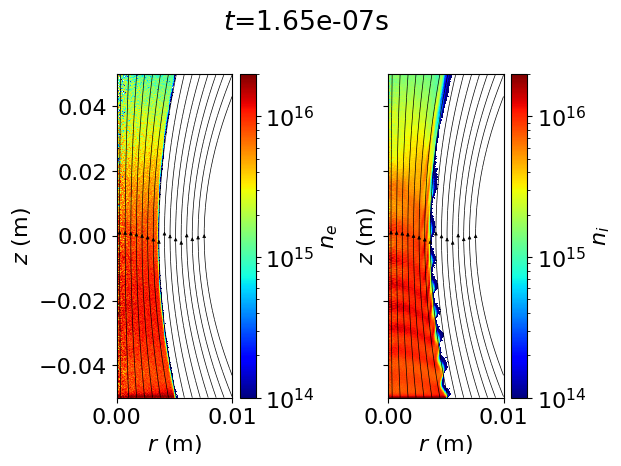

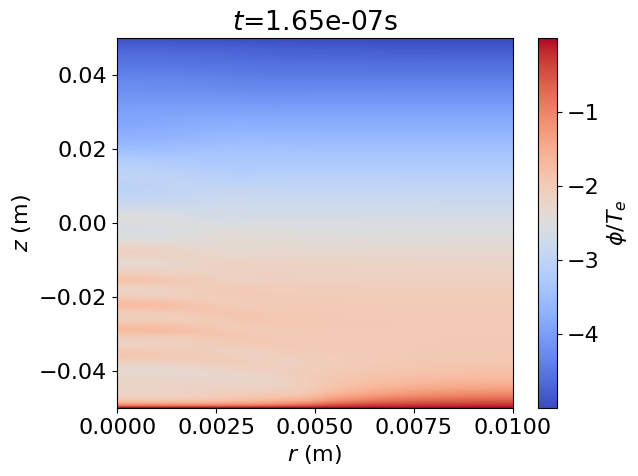

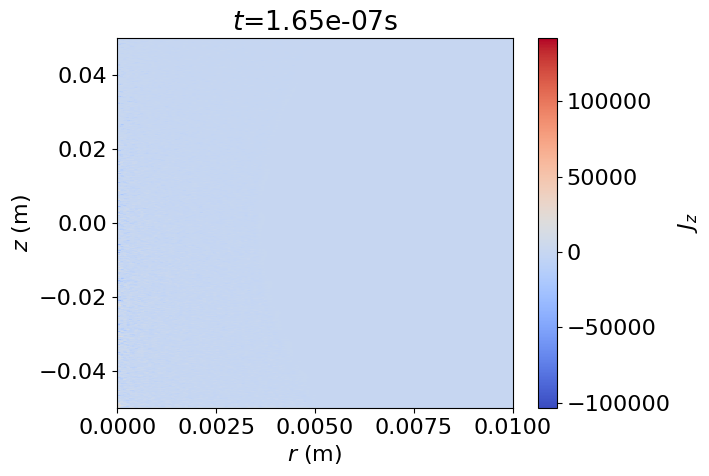

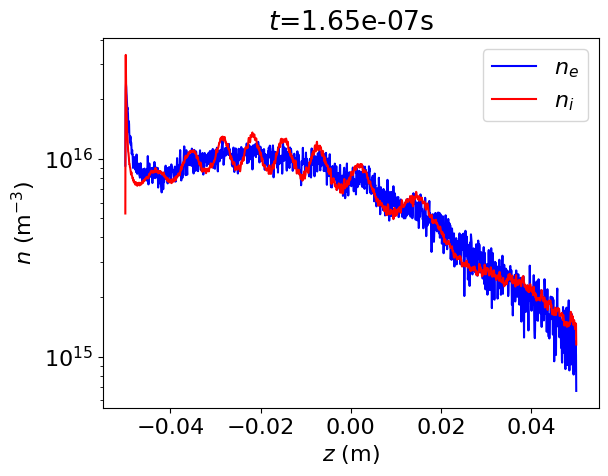

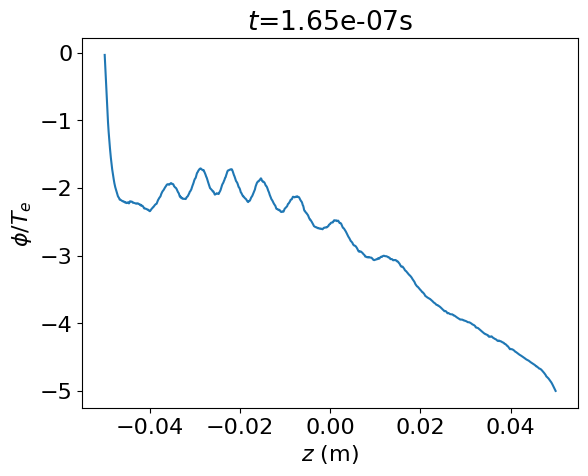

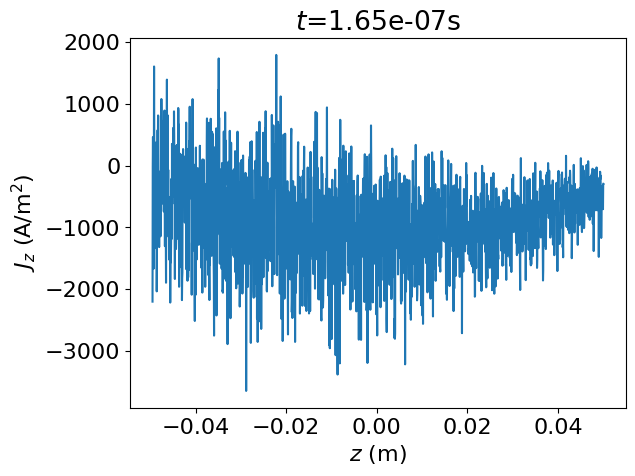

In [4]:
frame = -1
for plot_type in ["slice", "line"]:
    # analysis.plot_momentum(frame, plot_type=plot_type)
    analysis.plot_density(frame, plot_type=plot_type)
    analysis.plot_potential(frame, plot_type=plot_type)
    analysis.plot_current_density(frame, direction="z", plot_type=plot_type)
# analysis.plot_part_per_cell(frame)
# analysis.plot_time(total_step=100000)